In [1]:
# !apt-get update && apt-get install libgl1 -y

In [2]:
# pip install dask pandas numpy matplotlib seaborn torch scikit-learn opencv-python

In [3]:
# !unzip archive.zip

# Introduction

**Objectives**: train and apply knowledge about Convolutional Neural Network to create and train a model to predict the weather from an image.

**Technologies Used**:

**Pytorch** for load the data, build the model architeture, train it and avaliate it with new images.

**OpenCV** for image reading and processing.

**Pandas and NumPy** for data manipulation and organization.

**Scikit-Learn** for metric, classification report and train_test_split.

**Matplotlib and Seaborn** for Data and Images Visualization

# Imports

In [4]:
# - Data Manipulation - #
import numpy as np
import pandas as pd
import dask.array as da
import dask
from dask.diagnostics import ProgressBar

# - Data Visualization and Image Transformation - #
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import cv2

# - Datasets manipulation and Neural Network - #
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# - Data Preparation and Model Validation - #
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


# - Utils - #
import time
import gc
import requests
import os

In [5]:
# - Get the Font - #
url = "https://github.com/lucas142129silva/Movies-Exploratory-Data-Analysis/blob/main/fonts/FRAMD_M.ttf?raw=true"
r = requests.get(url)
with open("./framd_m.ttf", "wb") as f:
    f.write(r.content)

font = fm.FontProperties(fname="./framd_m.ttf")

In [6]:
cd /home

/home


# Reading the data

In [7]:
data = list()

for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        label = dirname.split("/")[-1]
        image = os.path.join(dirname, filename)
        data.append((label, image))

In [8]:
df = pd.DataFrame(data, columns=["label", "image"])
df.head()

,label,image
0,dew,./dataset/dew/2208.jpg
1,dew,./dataset/dew/2209.jpg
2,dew,./dataset/dew/2210.jpg
3,dew,./dataset/dew/2211.jpg
4,dew,./dataset/dew/2212.jpg


In [9]:
df.describe()

,label,image
count,6862,6862
unique,11,6862
top,rime,./dataset/dew/2208.jpg
freq,1160,1


In [10]:
unique_labels = df['label'].unique()
unique_labels

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

In [11]:
examples = pd.DataFrame([])
for label in unique_labels:
    examples = pd.concat([examples, df.query(f"label == '{label}'").sample(1)])

# Transforming the data

**Transform paths into arrays**: Pytorch can handle float32 NumPy arrays, so it reads using the OpenCV library and transform the image into a NumPy array resized to 256 x 256.

In [12]:
def process_image(img):
    try:
        pic = cv2.imread(img)
        pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
        pic = cv2.resize(pic, (256, 256), interpolation=cv2.INTER_AREA)
        pic = np.array(pic, dtype=np.float32)
        return pic
    except:
        return np.zeros(shape=(256, 256, 3), dtype=np.float32)

In [13]:
list_of_paths = df["image"].to_numpy()

## Using numpy array

In [14]:
%%time

images = [process_image(path) for path in list_of_paths]
images = np.array(images, dtype=np.float32)
print(images.shape)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


(6862, 256, 256, 3)
CPU times: user 1min 13s, sys: 3min 28s, total: 4min 41s
Wall time: 32.7 s


## Using Dask delayed

In [15]:
%%time
process_image_delayed = dask.delayed(process_image)
images = [process_image_delayed(path) for path in list_of_paths]

# Compute the results in parallel
with ProgressBar():
    images = dask.compute(*images)

# Convert the list to a Dask array
images = da.from_array(np.array(images, dtype=np.float32))
images = images.compute()
print(images.shape)

[#######                                 ] | 19% Completed | 724.04 ms

libpng warning: iCCP: known incorrect sRGB profile


[#########################               ] | 64% Completed | 2.38 s ms

libpng warning: iCCP: known incorrect sRGB profile


[##############################          ] | 75% Completed | 2.79 s

libpng warning: iCCP: known incorrect sRGB profile


[########################################] | 100% Completed | 3.80 s
(6862, 256, 256, 3)
CPU times: user 45.3 s, sys: 28.4 s, total: 1min 13s
Wall time: 8.08 s


# Vectorizing the labels 

Machine Learning models use numeric values, so it transform each array into its unique value, numbers in the lengh of the total of labels.

In [16]:
unique_labels = list(unique_labels) # Use for indexing the labels - ("hail", 0), ("rainbow", 1)

labels = df["label"].to_numpy()

# Using the unique labels list
def convert_categorical_to_number(label):
    return unique_labels.index(label)

func = np.vectorize(convert_categorical_to_number)
labels = func(labels)
labels

array([ 0,  0,  0, ..., 10, 10, 10])

# Preparing the data

### Split into train and test

In [17]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2)

In [18]:
print("Sizes:\n")
print("# - Train", images_train.shape, sep="\n")
print(labels_train.shape)
print("# - Test", images_test.shape, sep="\n")
print(labels_test.shape)

Sizes:

# - Train
(5489, 256, 256, 3)
(5489,)
# - Test
(1373, 256, 256, 3)
(1373,)


### Tranforming the data into Torch Tensor

The torch tensor has its size like (Batch x Color Channels x Height x Width), so it needs to permute the dimensions to get it right for images that have its size from readind like (Batch x Height x Width x Color Channels)

In [19]:
images_train = torch.from_numpy(images_train).permute(0, 3, 1, 2)
images_test = torch.from_numpy(images_test).permute(0, 3, 1, 2)
labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

In [20]:
# Free Memory
del images
_ = gc.collect()

# Defining the hyperparameters

In [21]:
# Hyperparams Configuration.
args = {
    'epoch_num': 20,
    'lr': 1e-3,           # Learning Rate
    'weight_decay': 1e-3, # L2 Penalty
    'batch_size': 256
}

# Checking the number of GPU available

In [22]:
if torch.cuda.is_available():
    args["device"] = torch.device("cuda:0")
else:
    args["device"] = torch.device("cpu")

print(args["device"])

cuda:0


In [23]:
gpu_count = torch.cuda.device_count()
print("Number of available GPUs:", gpu_count)

Number of available GPUs: 4


# Building the dataloader

In [24]:
class ImagesLabelsDataset(Dataset):
    def __init__(self, images_array, labels_array, scaler_feat=None, scaler_label=None):

        self.labels = labels_array
        self.images = images_array

    def __getitem__(self, idx):

        sample = self.images[idx]
        label  = self.labels[idx]

        return sample, label

    def __len__(self):
        return len(self.labels)

In [25]:
# - Dataset first - #
train_set = ImagesLabelsDataset(images_train, labels_train)
test_set = ImagesLabelsDataset(images_test, labels_test)

# - Dataloader - #
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         shuffle=False)

In [26]:
for batch in train_loader:
    img, lbl = batch
    print('## Batch shape ##')
    print(img.size(), lbl.size())
    break

## Batch shape ##
torch.Size([256, 3, 256, 256]) torch.Size([256])


# Model Architecture

In [27]:
class ConvolutionalModel(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.net = nn.Sequential(
            ## ConvBlock 1
            nn.Conv2d(3, 6, kernel_size=4, stride=1, padding=0),
            # Input: (b, 3, 256, 256) || Output: (b, 6, 250, 250)
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=5, stride=5, padding=0),
            # Input: (b, 6, 250, 250) || Output: (b, 6, 50, 50)

            ## ConvBlock 2
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            # Input: (b, 6, 50, 50) || Output: (b, 16, 46, 46)
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            # Input: (b, 16, 46, 46) || Output: (b, 16, 23, 23)

            ## ConvBlock 3
            nn.Conv2d(16, 32, kernel_size=8, stride=1, padding=0),
            # Input: (b, 16, 23, 23) || Output: (b, 32, 16, 16)
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=4, stride=4, padding=0),
            # Input: (b, 32, 16, 16) || Output: (b, 32, 4, 4)

            ## ConvBlock 4
            nn.Conv2d(32, 120, kernel_size=4, stride=1, padding=0),
            # Input: (b, 32, 4, 4) || Output: (b, 120, 1, 1)
            nn.BatchNorm2d(120),
            nn.Tanh(),
            nn.Flatten(),  # flat to a vector
            # Input: (b, 120, 1, 1) || Output: (b, 120*1*1) = (b, 120)

            nn.Dropout(p=0.32), # Avoid Overfitting
            ## DenseBlock
            nn.Linear(120, 84),
            # Input: (b, 120) || Output: (b, 84)
            nn.Tanh(),
            nn.Linear(84, output_size)
            # Input: (b, 84) || Output: (b, 10)
        )

    def forward(self, X):
        output = self.net(X)
        return output

In [28]:
net = ConvolutionalModel(len(unique_labels)).to(args["device"])

In [29]:
# # os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# available_gpus

# Implementing DataParallel approach 

In [30]:
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

### Training Parameters

The loss function chosen was Cross Entropy Loss while the optimizer was Adam, with the hyperparams defined by the arguments dictionary

In [31]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = torch.optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

### Train and Eval functions

In [32]:
def train(train_loader, net, epoch):
    net.train()
    start = time.time()

    epoch_loss = list()
    pred_list, label_list = np.array([]), np.array([])

    for batch in train_loader:
        image, label = batch

        # GPU Casting
        image = image.to(args["device"])
        label = label.to(args["device"])

        # Forward
        pred_label = net(image)
        loss = criterion(pred_label, label)
        epoch_loss.append(loss.cpu().data)

        _, pred = torch.max(pred_label, axis=1)
        pred_list = np.append(pred_list, pred.cpu().numpy())
        label_list = np.append(label_list, label.cpu().numpy())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = np.asarray(epoch_loss)
    epoch_acc = accuracy_score(label_list, pred_list)
    end = time.time()

    print("## -- Training -- ##")
    print("Epoch: %d || Loss: %.3f +/- %.3f || Accuracy:  %.2f || Time: %.2f" % (epoch, epoch_loss.mean(),
                                                                                epoch_loss.std(), epoch_acc, end-start))

    return epoch_loss.mean()

def validate(test_loader, net, epoch):
    net.eval()
    start = time.time()

    epoch_loss = list()
    pred_list, label_list = np.array([]), np.array([])

    with torch.no_grad():
        for batch in test_loader:
            image, label = batch

            # Casting to GPU
            image = image.to(args["device"])
            label = label.to(args["device"])

            # Forward
            pred_label = net(image)
            loss = criterion(pred_label, label)
            epoch_loss.append(loss.cpu().data)

            _, pred = torch.max(pred_label, axis=1)
            pred_list = np.append(pred_list, pred.cpu().numpy())
            label_list = np.append(label_list, label.cpu().numpy())

    # Transforming to NumPy Array
    epoch_loss = np.asarray(epoch_loss)
    epoch_acc = accuracy_score(label_list, pred_list)
    end = time.time()

    print("*** Validate ***")
    print("Epoch: %d || Loss: %.3f +/- %.3f || Accuracy:  %.2f || Time: %.2f\n" % (epoch, epoch_loss.mean(),
                                                                                epoch_loss.std(), epoch_acc, end-start))

    return epoch_loss.mean()

### Training process

In [33]:
%%time

train_losses, test_losses = list(), list()

for epoch in range(args["epoch_num"]):
    train_losses.append(train(train_loader, net, epoch))

    test_losses.append(validate(test_loader, net, epoch))

## -- Training -- ##
Epoch: 0 || Loss: 1.886 +/- 0.193 || Accuracy:  0.41 || Time: 8.23
*** Validate ***
Epoch: 0 || Loss: 1.793 +/- 0.042 || Accuracy:  0.40 || Time: 1.05

## -- Training -- ##
Epoch: 1 || Loss: 1.591 +/- 0.077 || Accuracy:  0.50 || Time: 4.26
*** Validate ***
Epoch: 1 || Loss: 1.715 +/- 0.070 || Accuracy:  0.42 || Time: 1.04

## -- Training -- ##
Epoch: 2 || Loss: 1.511 +/- 0.081 || Accuracy:  0.53 || Time: 4.35
*** Validate ***
Epoch: 2 || Loss: 1.540 +/- 0.039 || Accuracy:  0.52 || Time: 1.04

## -- Training -- ##
Epoch: 3 || Loss: 1.419 +/- 0.099 || Accuracy:  0.55 || Time: 4.25
*** Validate ***
Epoch: 3 || Loss: 1.442 +/- 0.052 || Accuracy:  0.52 || Time: 1.04

## -- Training -- ##
Epoch: 4 || Loss: 1.344 +/- 0.082 || Accuracy:  0.57 || Time: 4.35
*** Validate ***
Epoch: 4 || Loss: 1.328 +/- 0.055 || Accuracy:  0.57 || Time: 1.04

## -- Training -- ##
Epoch: 5 || Loss: 1.268 +/- 0.084 || Accuracy:  0.60 || Time: 4.35
*** Validate ***
Epoch: 5 || Loss: 1.331 +/- 0.

# Training Results

In [34]:
# Real Test Values 
validation_images = test_set.images.to(args["device"]) 
validation_labels = test_set.labels

# Predict
y_pred = np.array([np.argmax(net(image.unsqueeze(0)).cpu().detach().numpy()) for image in validation_images])

# Transform the numeric label back to string
validation_labels = list(map(lambda x: unique_labels[x], validation_labels))
y_pred = list(map(lambda x: unique_labels[x], y_pred))

In [35]:
# Transform the report into a DataFrame
report = classification_report(validation_labels, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df.index = [i.title() for i in report_df.index]
report_df.columns = [j.title() for j in report_df.columns]

### Classification Report

In [36]:
col_map = sns.color_palette("coolwarm_r", as_cmap=True)
report_df.style.background_gradient(subset="Precision", cmap=col_map)\
               .background_gradient(subset="Recall", cmap=col_map)\
               .background_gradient(subset="F1-Score", cmap=col_map)\
               .set_properties(**{"font-size": "11pt"})


,Precision,Recall,F1-Score,Support
Dew,0.722973,0.849206,0.781022,126.000000
Fogsmog,0.514970,0.924731,0.661538,186.000000
Frost,0.600000,0.170455,0.265487,88.000000
Glaze,0.406250,0.314516,0.354545,124.000000
Hail,0.586538,0.429577,0.495935,142.000000
Lightning,0.758065,0.635135,0.691176,74.000000
Rain,0.589744,0.460000,0.516854,100.000000
Rainbow,0.230088,0.565217,0.327044,46.000000
Rime,0.698565,0.610879,0.651786,239.000000
Sandstorm,0.650000,0.787879,0.712329,132.000000


The poor prediction results on labels Frost, Glaze and Snow probably means that the model have a difficult to differentiate them in reason of their similarity. Fogsmog and Sandstorm have a excellent classification score because of remarkable differences of these weathers from others.

# Validating the model

Randomly selected 2 images for each label and predicted. To better visualization, it plots the image with the legend of its true label and the predicted label.

In [37]:
sample_labels = unique_labels * 2
sample_labels.sort()

sample_images = np.array([])
np.random.seed(404)
for label in sample_labels:
    sample = df.query("label == '%s'" % label).sample(1)
    sample_images = np.append(sample_images, sample["image"].values)

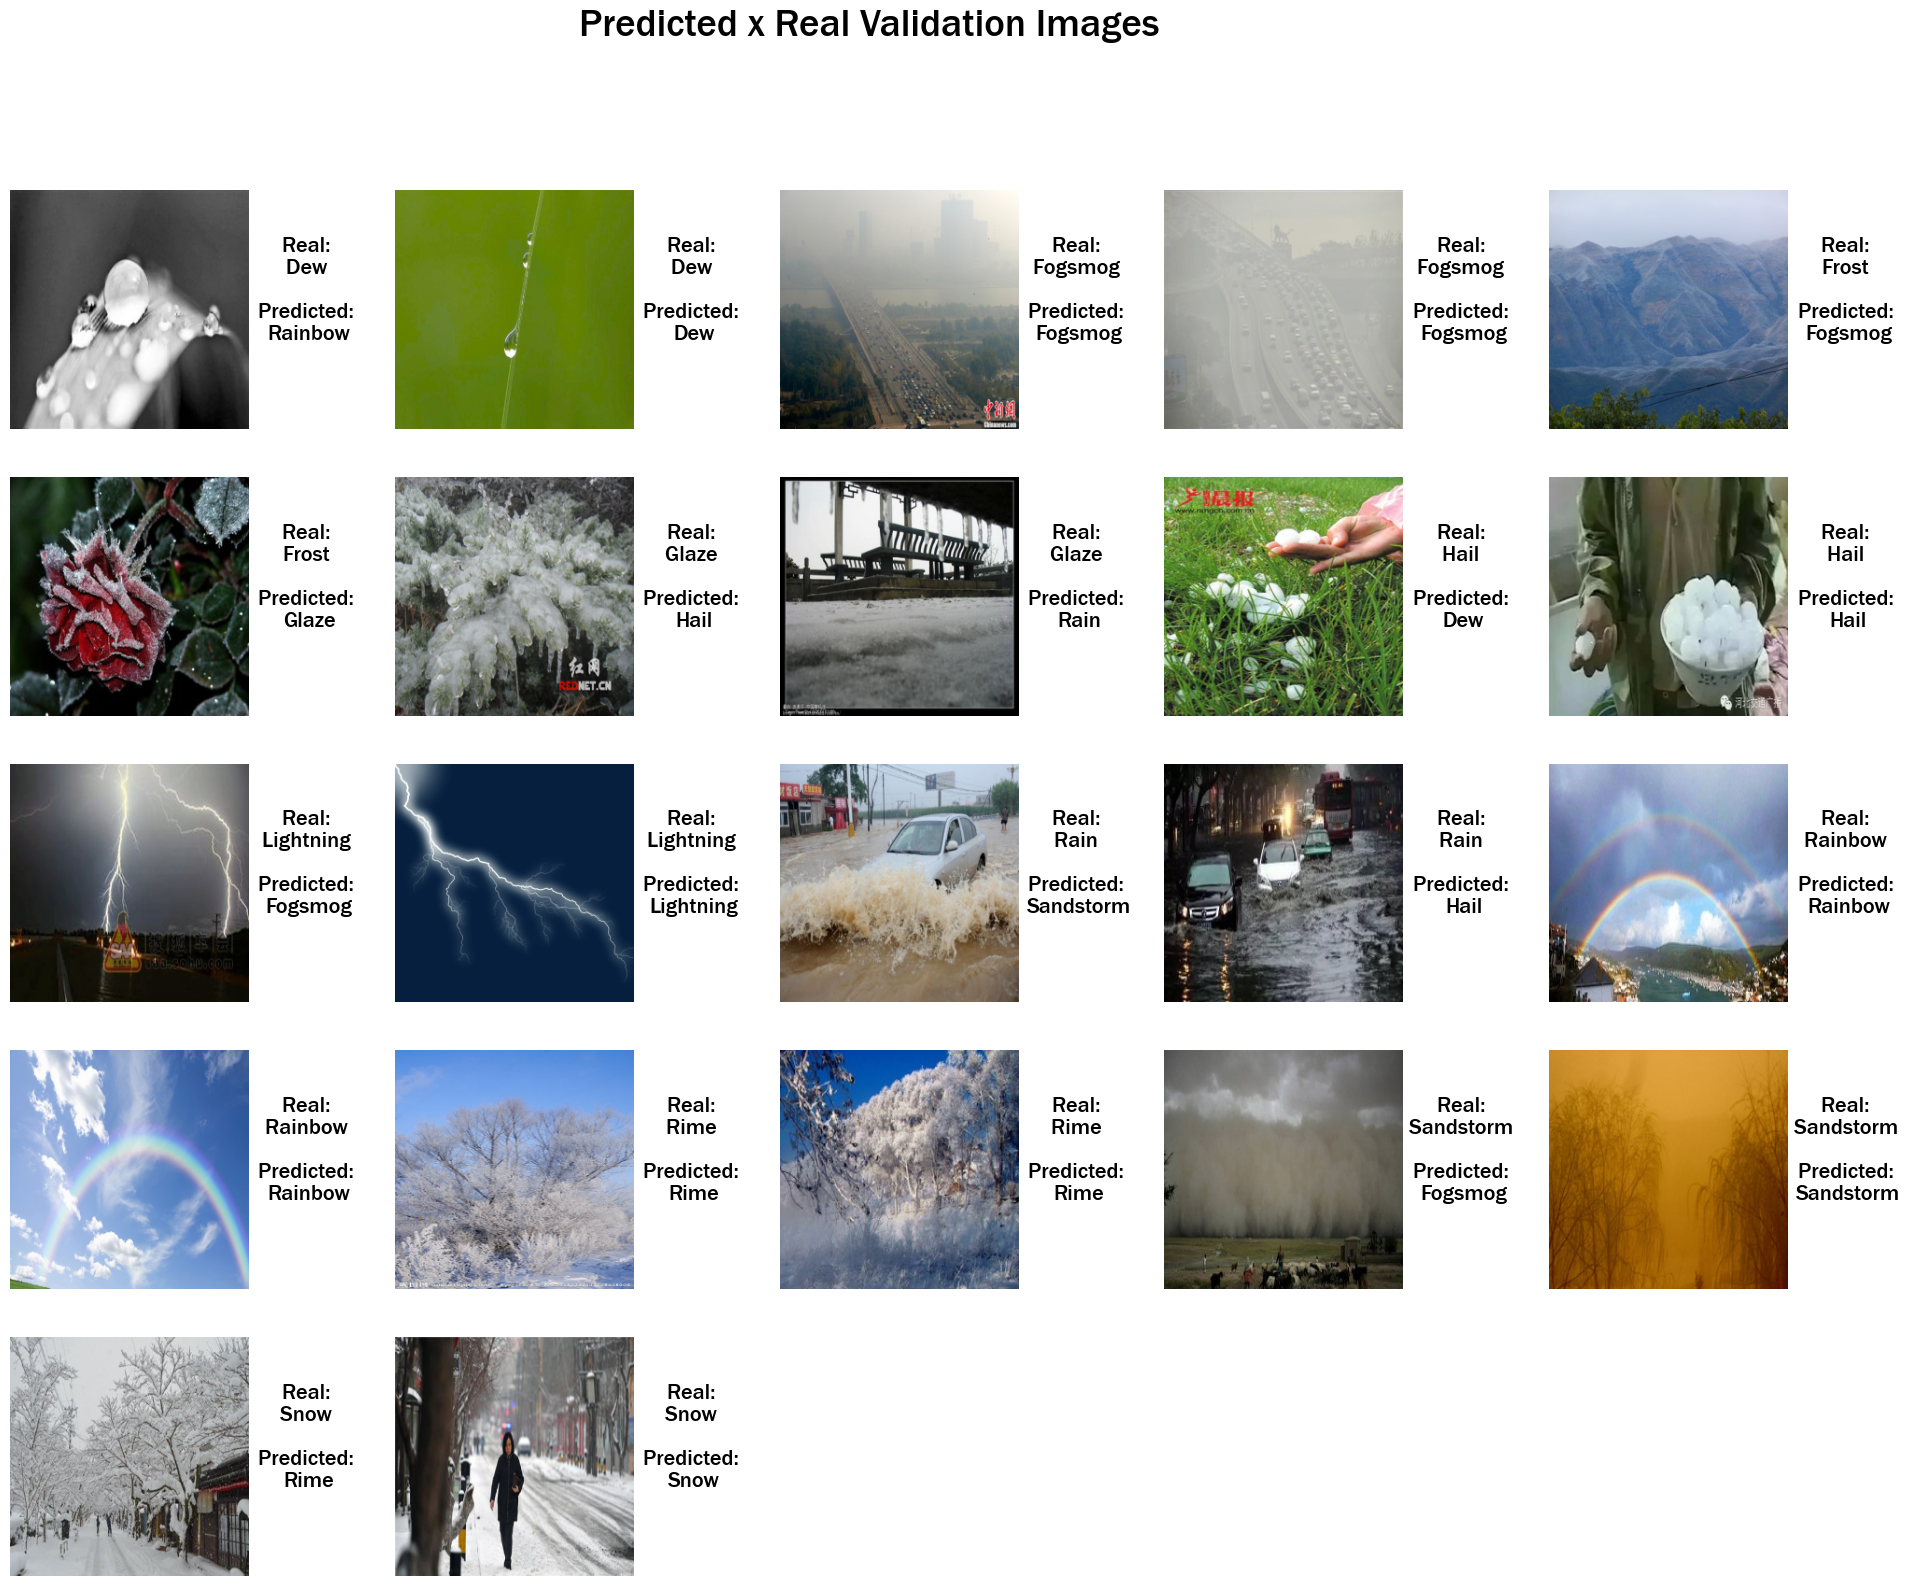

In [38]:
plt.figure(figsize=(24, 18))

for j, img in enumerate(sample_images):
    ax = plt.subplot(5, 5, j + 1)
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
    
    plt.imshow(image)
    plt.axis("off")
    
    image = np.array(image, dtype=np.float32)
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(args["device"])
    index = np.argmax(net(image_tensor).cpu().detach().numpy())
    y_pred = unique_labels[index]
    
    text = "Real: \n%s \n\nPredicted: \n%s" % (sample_labels[j].title(), y_pred.title())
    ax.text(s=text, y=160, x=320, fontsize=16, font=font, ha="center")

plt.suptitle("Predicted x Real Validation Images", font=font, fontsize=28)
plt.show()

As verified before, the model mistakes Frost with Glaze and Rime because of their similarities. The remainder labels generalized very well.

#  Conclusion

The model mistakes Frost with Hail and Rime in evaluation, that increases the loss in validation during training.
The model has an accuracy of 58% in new images.

In this notebook we implemented the training on 4xRTX3070 GPUs using **DataParallel** method and got a wall time of **1min 51secs** for training of 20 epochs 

Notebook Contributions: Dushyant Mahajan & Soeb Hussain